# Tom and Jerry Image Classification
https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import squarify
from skimage.feature import graycomatrix, graycoprops
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Initialize

In [2]:
data_dir = './kaggle/input/tom_and_jerry/tom_and_jerry'
image_size = (224, 224)
subfolders = ['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']
label_categories = ["Jerry","Tom","None","Both"]

### Tom & Jerry Label Balance

Jerry: 1240  Tom: 1930  None: 1528  Both: 780  

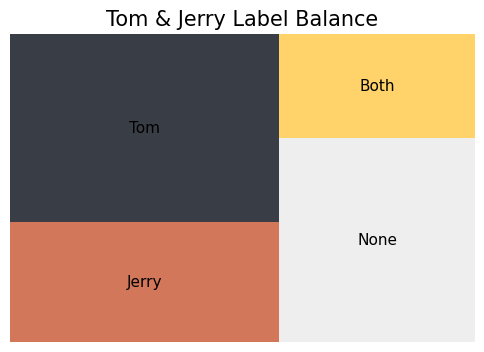

In [3]:
# Get the number of images for each class
image_counts = [len(os.listdir(os.path.join(data_dir, label))) for label in subfolders]

# Create a squarify plot of the class distribution
fig = plt.subplots(figsize = (6, 4))
# jerry, tom, none, both
colors = [ '#d27759','#393E46', '#EEEEEE',  '#FFD369']

squarify.plot(image_counts, label = label_categories, color = colors, text_kwargs = {"fontsize": 11})

plt.title("Tom & Jerry Label Balance", fontsize = 15)
plt.axis("off")

for i, count in enumerate(image_counts):
    print(f"{label_categories[i]}: {count}", end="  ")

## Functions to extract features of an image

In [4]:
# Function to preprocess the image
def preprocess_image(image):
    # Resize the image to a fixed size
    resized_image = cv2.resize(image, image_size)
    return resized_image

# Function to extract color histogram features
def extract_avg_rgb(image):
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
    # Calculate the average RGB values
    average_rgb = np.mean(image_rgb, axis=(0, 1))
    return average_rgb

def extract_color_histogram(image):
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Function to extract texture features using Gray-Level Co-occurrence Matrix (GLCM)
def extract_texture_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, [5], [0], 256, symmetric=True, normed=True)
    texture_features = np.hstack([graycoprops(glcm, prop).ravel() for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']])
    return texture_features

# Function to extract shape features
def extract_shape_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        contour_areas = [cv2.contourArea(contour) for contour in contours]
        return [len(contours), max(contour_areas), sum(contour_areas)]
    else:
        # If no contours are found, return null value
        return [None, None, None]  


# Function to extract colors of tom and jerry features
def extract_colors_features(image):
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Calculate the percentage of pixels in the image that match the color of Tom or Jerry
    tom_color_1 = np.array([95, 92, 87])  # Tom's characteristic color 1
    tom_color_2 = np.array([6, 69, 92])    # Tom's characteristic color 2
    tom_color_3 = np.array([195, 196, 191])    # Tom's characteristic color 3
    jerry_color_1 = np.array([140, 67, 41])  # Jerry's characteristic color 1
    jerry_color_2 = np.array([118, 64, 37])   # Jerry's characteristic color 2
    jerry_color_3 = np.array([225, 159, 115])   # Jerry's characteristic color 3


    
    # Calculate the mask for pixels matching the color of Tom or Jerry
    tom_mask = np.any(np.isclose(image_rgb, tom_color_1, atol=4), axis=-1) \
               | np.any(np.isclose(image_rgb, tom_color_2, atol=4), axis=-1) \
               | np.any(np.isclose(image_rgb, tom_color_3, atol=4), axis=-1) 
    jerry_mask = np.any(np.isclose(image_rgb, jerry_color_1, atol=1), axis=-1) \
                 | np.any(np.isclose(image_rgb, jerry_color_2, atol=1), axis=-1) \
                 | np.any(np.isclose(image_rgb, jerry_color_3, atol=1), axis=-1) 

    
    tom_pixel_percentage = np.mean(tom_mask)
    jerry_pixel_percentage = np.mean(jerry_mask) 
    return tom_pixel_percentage,  jerry_pixel_percentage

# Function to extract edge features using Canny edge detection
def extract_edge_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges) / (gray.shape[0] * gray.shape[1])  # Edge density
    return edge_density

# Function to extract Gabor features
def extract_gabor_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    frequencies = [0.1, 0.3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    features = []
    for frequency in frequencies:
        for angle in angles:
            g_kernel = cv2.getGaborKernel((21, 21), 4.0, angle, frequency, 0.5, 0, ktype=cv2.CV_32F)
            filtered = cv2.filter2D(gray, cv2.CV_32F, g_kernel)
            features.append(np.mean(filtered))
            features.append(np.std(filtered))
    return np.array(features)



# Function to extract features for each image
def extract_features(image_path):
    image = cv2.imread(image_path)
    image = preprocess_image(image)
    
    avg_rgb = extract_avg_rgb(image)
    avg_rgb_columns = {'Avg_RGB_R': avg_rgb[0],'Avg_RGB_g': avg_rgb[1], 'Avg_RGB_B': avg_rgb[2] }
    
    color_hist = extract_color_histogram(image)
    color_hist_columns = {'Color_Hist_'+str(i+1): hist_val for i, hist_val in enumerate(color_hist)}
    
    texture_features = extract_texture_features(image)
    texture_columns = {'Texture_'+prop: val for prop, val in zip(['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation'], texture_features)}

    shape_features = extract_shape_features(image)
    shape_columns = {'Shape_'+prop: val for prop, val in zip(['num_contours', 'max_contour_area', 'total_contour_area'], shape_features)}

    edge_density = extract_edge_features(image)
    edge_columns = {'Edge_Density': edge_density}

    tom_pixel_percentage, jerry_pixel_percentage = extract_colors_features(image)
    colors_columns = {'Tom_Pixel_Percentage': tom_pixel_percentage, 'Jerry_Pixel_Percentage': jerry_pixel_percentage}
    
    gabor_features = extract_gabor_features(image)
    gabor_columns = {'Gabor_'+str(i+1): g for i, g in enumerate(gabor_features)}
    
    all_columns = {**avg_rgb_columns, **color_hist_columns, **texture_columns, **shape_columns, **colors_columns, **edge_columns, **gabor_columns}

    return all_columns

## Create Dataframe with images data

In [5]:
data = []
image_files_list = []
labels = []

# Assuming subfolders is a list containing the subfolder names
for label, subfolder in enumerate(subfolders):
    folder_path = os.path.join(data_dir, subfolder)
    image_files = os.listdir(folder_path)
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        try:
            image_info = extract_features(image_path)
            # Add image info and label to lists
            image_files_list.append(os.path.join(subfolder, image_file))
            data.append(image_info)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

# Create a DataFrame

df = pd.DataFrame(data)
df.insert(0, 'image_file', image_files_list)
df['Label'] = labels


In [6]:
df

,image_file,Avg_RGB_R,Avg_RGB_g,Avg_RGB_B,Color_Hist_1,Color_Hist_2,Color_Hist_3,Color_Hist_4,Color_Hist_5,Color_Hist_6,...,Gabor_8,Gabor_9,Gabor_10,Gabor_11,Gabor_12,Gabor_13,Gabor_14,Gabor_15,Gabor_16,Label
0,jerry/frame4473.jpg,112.128966,107.991988,87.107043,0.738695,0.007636,0.006173,0.001464,0.001845,0.000000,...,990.069763,11.243255,215.093842,11.901139,25.546318,11.242497,36.563461,11.901108,22.493332,0
1,jerry/frame1993.jpg,57.381178,49.199617,47.366291,0.631921,0.019470,0.007706,0.000000,0.000000,0.000000,...,444.202972,5.413600,129.480072,5.730477,27.641449,5.427465,28.781691,5.730477,24.647722,0
2,jerry/frame3451.jpg,96.768694,93.071130,85.450175,0.647569,0.001296,0.002890,0.003489,0.000249,0.000000,...,686.010193,9.654404,36.972767,10.397233,15.547724,9.820609,170.957748,10.397232,23.802858,0
3,jerry/frame5203.jpg,41.836794,54.374522,41.357083,0.790529,0.102939,0.229653,0.006629,0.001260,0.000000,...,680.668335,5.174377,148.116776,5.480175,49.175797,5.209764,50.898315,5.480174,38.506248,0
4,jerry/frame3104.jpg,84.929309,81.601244,82.275092,0.682351,0.024456,0.009940,0.002419,0.001893,0.000473,...,732.463745,8.307537,218.928406,9.215004,46.053703,8.702504,155.955978,9.215003,40.235214,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5473,tom_jerry_1/frame2026.jpg,86.548131,73.331314,70.174845,0.738955,0.012140,0.002207,0.000123,0.000000,0.000000,...,760.405457,8.093649,191.474167,8.567028,36.348637,8.105532,48.182560,8.567026,28.276775,3
5474,tom_jerry_1/frame1566.jpg,101.828304,88.313257,85.636121,0.761413,0.016374,0.012870,0.002230,0.005415,0.000000,...,778.416321,9.686623,217.184601,10.253465,57.960831,9.691252,80.565857,10.253464,52.908016,3
5475,tom_jerry_1/frame3624.jpg,60.206593,61.571209,58.938915,0.911843,0.237741,0.148093,0.003386,0.000990,0.005522,...,802.651672,6.405029,214.850342,6.782672,42.497612,6.381378,68.716164,6.782672,35.823433,3
5476,tom_jerry_1/frame3919.jpg,89.874402,57.575474,58.514290,0.794688,0.079075,0.307674,0.099141,0.003751,0.000500,...,860.247620,7.087979,194.561981,7.504679,56.992088,7.066214,79.569244,7.504677,66.670219,3


Save original dataframe into csv

In [7]:
df.to_csv('./data/original_data.csv', index=False)

## Preproccesing

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5478 entries, 0 to 5477
Columns: 544 entries, image_file to Label
dtypes: float32(528), float64(14), int64(1), object(1)
memory usage: 11.7+ MB


In [9]:
df.columns[df.isnull().any()]

Index(['Shape_num_contours', 'Shape_max_contour_area',
       'Shape_total_contour_area'],
      dtype='object')

Impute nan values

In [10]:
df = df.fillna(df.drop(columns='image_file').mean())

### Split dataframe into training and testing

In [11]:
X = df.drop(columns=['image_file', 'Label'])  
y = df['Label'] 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create training DataFrame
train_df = X_train.copy()
train_df['Label'] = y_train

# Create testing DataFrame
test_df = X_test.copy()
test_df['Label'] = y_test

In [12]:
train_df

,Avg_RGB_R,Avg_RGB_g,Avg_RGB_B,Color_Hist_1,Color_Hist_2,Color_Hist_3,Color_Hist_4,Color_Hist_5,Color_Hist_6,Color_Hist_7,...,Gabor_8,Gabor_9,Gabor_10,Gabor_11,Gabor_12,Gabor_13,Gabor_14,Gabor_15,Gabor_16,Label
2572,81.612962,93.706892,77.136440,0.813881,0.008196,0.007576,0.008540,0.005579,0.018734,0.000689,...,693.027710,9.280107,201.332779,9.824826,50.387329,9.383692,73.364601,9.824825,50.014751,1
2078,130.834204,88.033941,87.154955,0.872282,0.004884,0.004483,0.006824,0.002208,0.002409,0.000401,...,856.379883,10.906687,105.821312,11.219876,61.329536,10.600244,201.437088,11.219876,56.601261,1
1034,66.387994,46.888652,46.320970,0.922435,0.079992,0.041058,0.000661,0.000047,0.000000,0.000000,...,674.080688,5.540370,140.903183,5.863691,31.570484,5.605275,70.342430,5.863690,41.436745,0
2890,140.306740,68.997090,77.228416,0.845699,0.002735,0.005926,0.051773,0.112534,0.020579,0.000000,...,787.388611,9.601084,181.223816,10.165711,50.955265,9.612167,198.423874,10.166024,46.564312,1
931,67.708785,132.869699,102.741729,0.745076,0.000319,0.000766,0.000702,0.000128,0.000000,0.000000,...,831.061279,11.579727,276.736206,12.269520,47.420834,10.290530,97.673225,12.269520,61.542694,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,19.706513,121.383909,138.792570,0.456951,0.000000,0.000730,0.006040,0.003243,0.000000,0.000000,...,688.101929,9.784740,141.701279,10.357677,10.951550,9.790706,93.783455,10.357676,26.304916,2
5191,84.675303,87.784778,86.567781,0.911641,0.025887,0.054664,0.038951,0.000060,0.000000,0.000000,...,921.337769,9.129214,194.275467,9.667126,60.950962,9.083165,87.496323,9.667126,53.696400,3
5226,111.925343,105.143455,131.442622,0.767189,0.000530,0.000589,0.000530,0.000000,0.000000,0.000000,...,906.251465,11.272657,160.865768,12.269365,49.548214,11.589926,206.645996,12.269320,43.832573,3
5390,101.426937,135.469208,95.654257,0.706662,0.002847,0.004907,0.008966,0.014418,0.000000,0.000000,...,875.022461,12.711942,265.459778,13.458458,46.424252,12.351921,92.077934,13.458455,49.537693,3


Save preprocessed train and test dataframes into csv

In [13]:
train_df.to_csv('./data/train_data.csv', index=False)
test_df.to_csv('./data/test_data.csv', index=False)

## Random Forest Classifier

Initialize the Random Forest classifier 

In [14]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Accuracy: 0.9023722627737226

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       269
           1       0.91      0.97      0.94       372
           2       0.88      0.90      0.89       295
           3       0.98      0.79      0.87       160

    accuracy                           0.90      1096
   macro avg       0.91      0.88      0.90      1096
weighted avg       0.90      0.90      0.90      1096



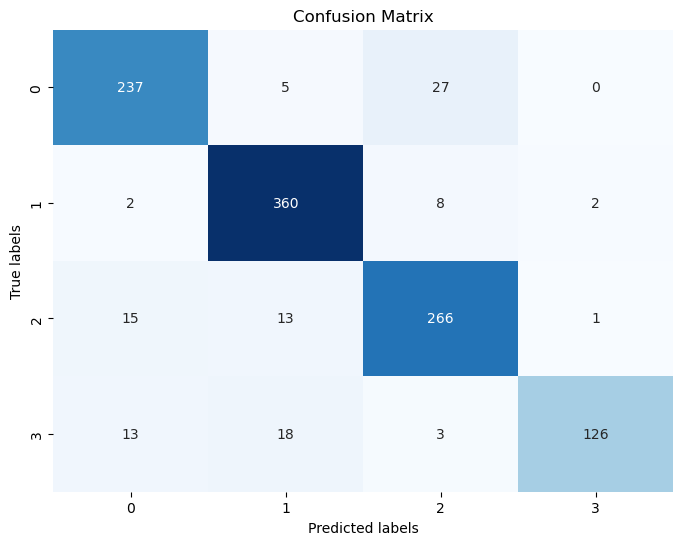

In [15]:
X_test = test_df.drop(columns=['Label'])
y_test = test_df['Label']

# Predict the labels for test data
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## K-means

In [16]:
correlation_matrix = df.drop(columns=['image_file', 'Label']).corr()
correlation_matrix

,Avg_RGB_R,Avg_RGB_g,Avg_RGB_B,Color_Hist_1,Color_Hist_2,Color_Hist_3,Color_Hist_4,Color_Hist_5,Color_Hist_6,Color_Hist_7,...,Gabor_7,Gabor_8,Gabor_9,Gabor_10,Gabor_11,Gabor_12,Gabor_13,Gabor_14,Gabor_15,Gabor_16
Avg_RGB_R,1.000000,0.576804,0.407522,-0.214302,-0.206022,-0.128037,0.040989,0.073115,0.062091,0.183449,...,0.788869,0.518094,0.697275,0.376640,0.789123,0.237225,0.793611,0.243017,0.789017,0.251075
Avg_RGB_g,0.576804,1.000000,0.754252,-0.420450,-0.351372,-0.285808,-0.210075,-0.162663,-0.166963,0.092419,...,0.951795,0.491570,0.895714,0.436249,0.951682,0.134939,0.947599,-0.038942,0.951725,0.110040
Avg_RGB_B,0.407522,0.754252,1.000000,-0.383653,-0.348580,-0.235058,-0.151235,-0.125474,-0.154455,0.092465,...,0.766112,0.463130,0.726041,0.439502,0.765858,0.143029,0.764484,-0.094003,0.765942,0.121939
Color_Hist_1,-0.214302,-0.420450,-0.383653,1.000000,0.242396,0.136156,0.090354,0.012028,0.021240,-0.274359,...,-0.398893,0.303592,-0.346572,0.065501,-0.399281,0.115788,-0.398147,0.185789,-0.399032,0.125831
Color_Hist_2,-0.206022,-0.351372,-0.348580,0.242396,1.000000,0.239574,0.104603,-0.015322,0.016275,-0.026926,...,-0.346892,-0.049356,-0.333141,-0.101009,-0.346851,0.019289,-0.344215,-0.039076,-0.346865,0.029134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gabor_12,0.237225,0.134939,0.143029,0.115788,0.019289,0.105135,0.079857,0.004986,0.041927,0.091494,...,0.192668,0.406358,0.111381,0.326512,0.193243,1.000000,0.193211,0.326223,0.193226,0.842788
Gabor_13,0.793611,0.947599,0.764484,-0.398147,-0.344215,-0.259397,-0.138380,-0.093994,-0.104244,0.139345,...,0.998813,0.566500,0.923089,0.476469,0.998792,0.193211,1.000000,0.051933,0.998791,0.180052
Gabor_14,0.243017,-0.038942,-0.094003,0.185789,-0.039076,-0.028092,0.044520,-0.003656,0.148371,-0.009500,...,0.051670,0.166444,-0.047453,-0.130813,0.052305,0.326223,0.051933,1.000000,0.052349,0.375216
Gabor_15,0.789017,0.951725,0.765942,-0.399032,-0.346865,-0.260723,-0.140019,-0.094420,-0.104677,0.138336,...,0.999994,0.565894,0.923218,0.476668,0.999998,0.193226,0.998791,0.052349,1.000000,0.179465


Function to check if a combination contains duplicate prefixes to avoid meaningless correlations

In [17]:
def has_duplicate_prefix(combination):
    prefixes = set()
    for column in combination:
        prefix = column.split('_')[0] 
        if prefix in prefixes:
            return True
        prefixes.add(prefix)
    return False

Iterate over all combinations of variables and check if their correlation exceeds the threshold

In [18]:
from itertools import combinations

combinations_variables = []
threshold = 0.8  # Correlation threshold

for combination in combinations(correlation_matrix.columns, 3):
    if has_duplicate_prefix(combination):
        continue
    correlation_sum = 0
    count = 0
    for i in range(len(combination)):
        for j in range(i + 1, len(combination)):
            correlation_sum += abs(correlation_matrix.loc[combination[i], combination[j]])
            count += 1
    average_correlation = correlation_sum / count
    if average_correlation > threshold:
        combinations_variables.append(list(combination))

Perform clustering with different variable combinations and numbers of clusters

In [19]:
best_combination = None
best_silhouette_score = -1
best_labels = None

for idx, variables in enumerate(combinations_variables):
    for n_clusters in range(3, 6):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
        kmeans.fit(df[variables])
        silhouette_avg = silhouette_score(df[variables], kmeans.labels_)

        if silhouette_avg > best_silhouette_score:
            best_combination = (variables, n_clusters)
            best_silhouette_score = silhouette_avg
            best_labels = kmeans.labels_
            
print(f'Best combination: {best_combination}, Silhouette Score: {best_silhouette_score}')

Best combination: (['Avg_RGB_g', 'Shape_max_contour_area', 'Gabor_13'], 3), Silhouette Score: 0.6114738574437253


Create a DataFrame for the selected variables and their assigned clusters

In [20]:
df_cluster = df[['image_file']+ best_combination[0]].copy()
df_cluster['Cluster'] = best_labels
df_cluster

,image_file,Avg_RGB_g,Shape_max_contour_area,Gabor_13,Cluster
0,jerry/frame4473.jpg,107.991988,17356.5,11.242497,0
1,jerry/frame1993.jpg,49.199617,788.0,5.427465,1
2,jerry/frame3451.jpg,93.071130,21198.5,9.820609,0
3,jerry/frame5203.jpg,54.374522,1191.5,5.209764,1
4,jerry/frame3104.jpg,81.601244,5977.0,8.702504,1
...,...,...,...,...,...
5473,tom_jerry_1/frame2026.jpg,73.331314,9152.0,8.105532,1
5474,tom_jerry_1/frame1566.jpg,88.313257,7460.5,9.691252,1
5475,tom_jerry_1/frame3624.jpg,61.571209,7572.5,6.381378,1
5476,tom_jerry_1/frame3919.jpg,57.575474,10304.0,7.066214,1


### Analysis across clusters

Do .describe() for each cluster

In [21]:
for cluster_label in df_cluster['Cluster'].unique():
    print(f"\nCluster {cluster_label}:")
    print(df_cluster[df_cluster['Cluster'] == cluster_label].drop(columns=['image_file', 'Cluster']).describe())


Cluster 0:
         Avg_RGB_g  Shape_max_contour_area     Gabor_13
count  1698.000000             1698.000000  1698.000000
mean     95.822542            16392.641869    10.009725
std      16.675882             3580.546457     1.511558
min       0.000000            10427.000000     0.000000
25%      88.640904            13446.875000     9.474170
50%      97.812052            16186.750000    10.201918
75%     105.460350            19151.125000    10.774439
max     166.568499            23794.000000    17.056652

Cluster 1:
         Avg_RGB_g  Shape_max_contour_area     Gabor_13
count  2616.000000             2616.000000  2616.000000
mean     73.770317             4397.405390     7.588368
std      16.985196             3037.547618     1.544127
min      10.955915                0.000000     1.119382
25%      63.215815             1619.625000     6.574189
50%      73.807896             4122.000000     7.649641
75%      85.526307             6852.625000     8.716106
max     135.523736      


**1. Cluster 0 contains 1698 data points (30.99% of the total)**

- Avg_RGB_g: The mean average green value for this cluster is approximately 95.82, with a standard deviation of 16.68. The minimum value is 0, and the maximum value is 166.57.
- Shape_max_contour_area: The mean maximum contour area for this cluster is approximately 16392.64, with a standard deviation of 3580.55. The minimum value is 10427.00, and the maximum value is 23794.00.
- Gabor_13: The mean value for the Gabor feature 13 in this cluster is approximately 10.01, with a standard deviation of 1.51. The minimum value is 0.00, and the maximum value is 17.06.

**2. Cluster 1 contains 2616 data points (47.75 of the total)**

- Avg_RGB_g: The mean average green value for this cluster is approximately 73.77, with a standard deviation of 16.99. The minimum value is 10.96, and the maximum value is 135.52.
- Shape_max_contour_area: The mean maximum contour area for this cluster is approximately 4397.41, with a standard deviation of 3037.55. The minimum value is 0.00, and the maximum value is 10409.00.
- Gabor_13: The mean value for the Gabor feature 13 in this cluster is approximately 7.59, with a standard deviation of 1.54. The minimum value is 1.12, and the maximum value is 12.60.

**3. Cluster 2 contains 1164 data points (21.24% of the total)**

- Avg_RGB_g: The mean average green value for this cluster is approximately 123.24, with a standard deviation of 17.67. The minimum value is 76.93, and the maximum value is 193.23.
- Shape_max_contour_area: The mean maximum contour area for this cluster is approximately 31139.09, with a standard deviation of 5729.22. The minimum value is 23799.00, and the maximum value is 49694.50.
- Gabor_13: The mean value for the Gabor feature 13 in this cluster is approximately 12.49, with a standard deviation of 1.65. The minimum value is 8.51, and the maximum value is 19.32. 

Cluster 2 stands out for having significantly higher values in the features compared to the other clusters. It exhibits higher average green values and larger contour areas, suggesting potentially richer and more detailed images. Additionally, Cluster 2 also demonstrates higher mean values for the Gabor feature 13, indicating distinctive textural characteristics.

In contrast, Cluster 1 displays lower values across the features when compared to the other clusters. It is characterized by lower average green values and smaller contour areas, suggesting simpler and less detailed images. The mean value of Gabor feature 13 in Cluster 1 is also comparatively lower.

Cluster 0 falls between Clusters 1 and 2, exhibiting moderate values in the features. While it does not reach the extremes observed in Clusters 1 and 2, it still demonstrates notable characteristics, placing it in the middle ground in terms of feature values.


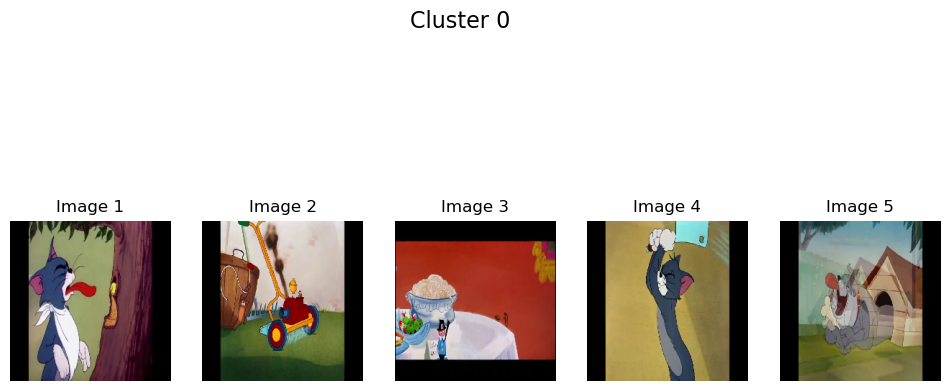

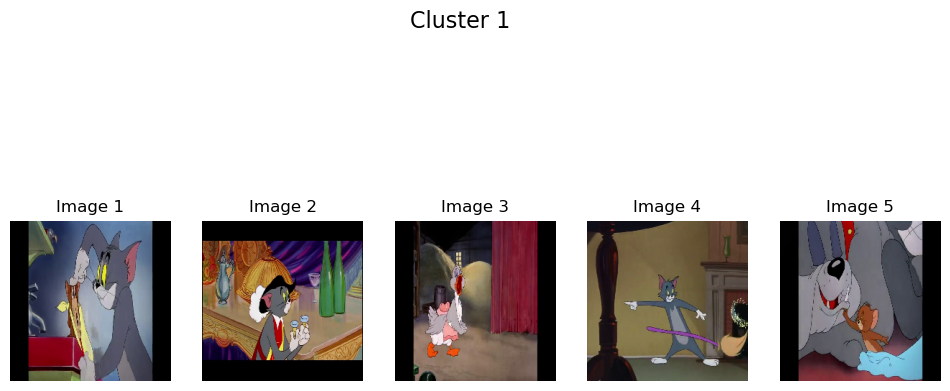

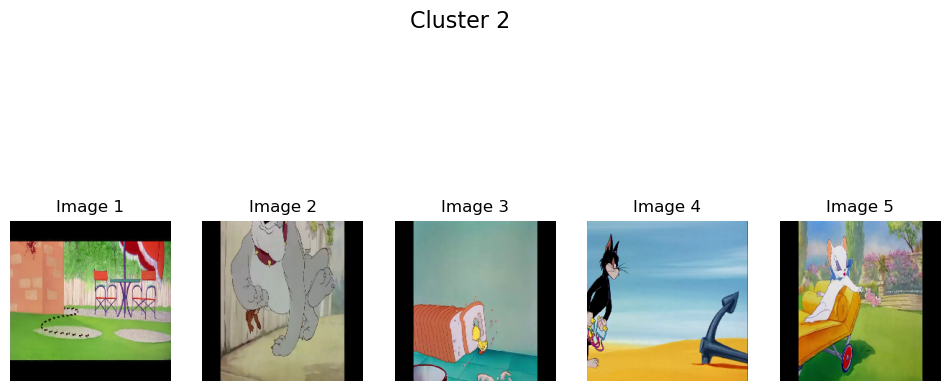

In [25]:
import tensorflow as tf

def display_image_clusters(df, data_dir):
    clusters = df['Cluster'].unique()
    
    for cluster_label in clusters:
        plt.figure(figsize=(12, 6))
        plt.suptitle(f"Cluster {cluster_label}", fontsize=16)
        
        subset = df[df['Cluster'] == cluster_label].sample(5, random_state=42)
        image_paths = subset['image_file'].apply(lambda x: os.path.join(data_dir, str(x))).tolist()
        
        for i, image_path in enumerate(image_paths):
            plt.subplot(1, 5, i + 1)
            img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Image {i+1}")

        plt.show()
display_image_clusters(df_cluster, data_dir)